In [1]:
from sklearn import cluster, datasets, mixture
noisy_moons=datasets.make_moons(n_samples=500, noise=0.11)

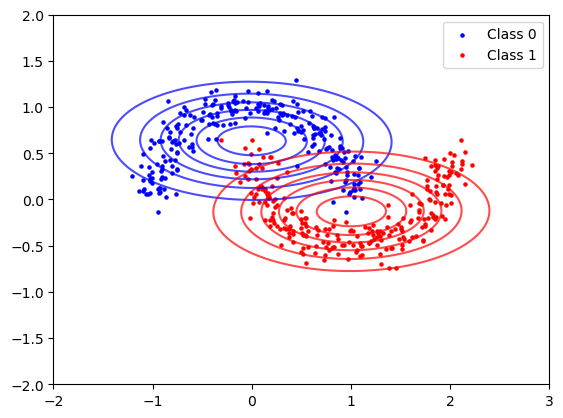

In [5]:
import numpy as np
import matplotlib.pyplot as plt


class_0 = noisy_moons[0][noisy_moons[1] == 0]
class_1 = noisy_moons[0][noisy_moons[1] == 1]

mean_class_0 = np.mean(class_0, axis=0)
cov_class_0 = np.cov(class_0, rowvar=False)
mean_class_1 = np.mean(class_1, axis=0)
cov_class_1 = np.cov(class_1, rowvar=False)

x, y = np.meshgrid(np.linspace(-2, 3, 500), np.linspace(-2, 2, 500))
xy = np.column_stack((x.ravel(), y.ravel()))

pdf_class_0 = (
    1 / (2 * np.pi * np.sqrt(np.linalg.det(cov_class_0))) *
    np.exp(-0.5 * np.sum((xy - mean_class_0).dot(np.linalg.inv(cov_class_0)) * (xy - mean_class_0), axis=1))
)
pdf_class_1 = (
    1 / (2 * np.pi * np.sqrt(np.linalg.det(cov_class_1))) *
    np.exp(-0.5 * np.sum((xy - mean_class_1).dot(np.linalg.inv(cov_class_1)) * (xy - mean_class_1), axis=1))
)

pdf_class_0 = pdf_class_0.reshape(x.shape)
pdf_class_1 = pdf_class_1.reshape(x.shape)

plt.scatter(class_0[:, 0], class_0[:, 1], s=5, label='Class 0', c='b')
plt.scatter(class_1[:, 0], class_1[:, 1], s=5, label='Class 1', c='r')

plt.contour(x, y, pdf_class_0, levels=None, colors='b', alpha=0.7)
plt.contour(x, y, pdf_class_1, levels=None, colors='r', alpha=0.7)

plt.legend()
plt.show()


# GMM

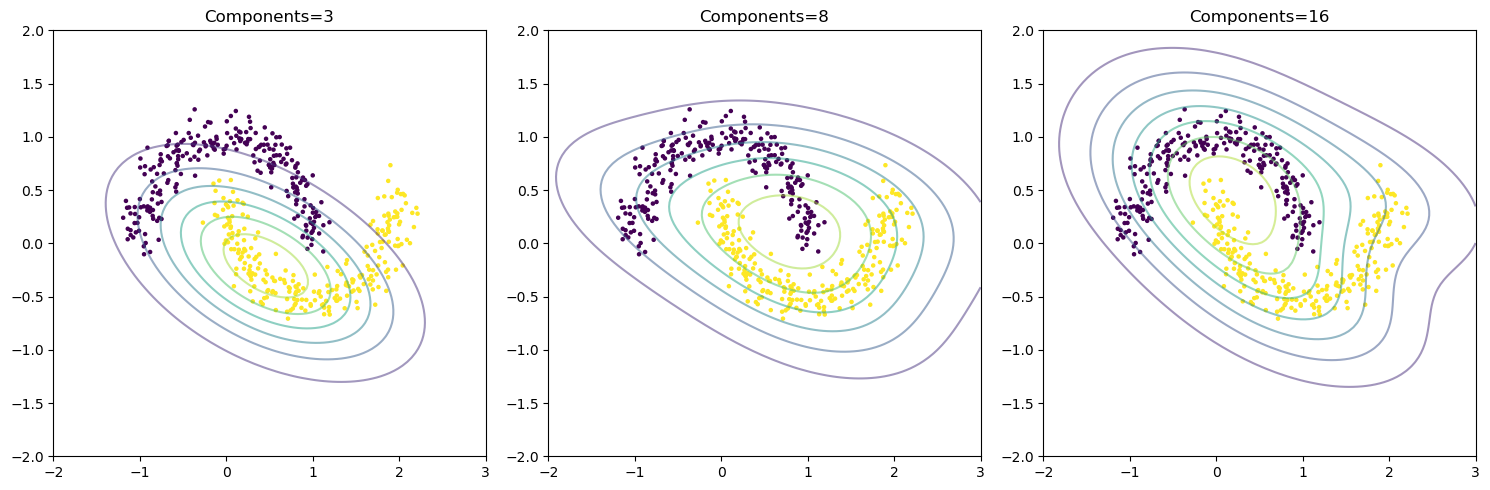

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Generate the noisy moons dataset
noisy_moons = datasets.make_moons(n_samples=500, noise=0.11)

# Define the range of components to test
n_components_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Create subplots for the selected number of components
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Numbers of components to visualize
components_to_visualize = [3, 8, 16]

# Define a function to calculate the Gaussian probability density
def gaussian_pdf(x, mean, cov):
    d = x - mean
    exponent = -0.5 * np.sum(d @ np.linalg.inv(cov) * d, axis=1)
    return (1.0 / (2 * np.pi * np.sqrt(np.linalg.det(cov))) * np.exp(exponent))

# Iterate through different numbers of components
for i, n_components in enumerate(n_components_range):
    # Fit GMM by calculating mean and covariance for each component
    means = []
    covs = []
    weights = []
    for _ in range(n_components):
        idx = np.random.choice(len(noisy_moons[0]))
        mean = noisy_moons[0][idx]
        cov = np.cov(noisy_moons[0].T)
        weight = 1.0 / n_components
        means.append(mean)
        covs.append(cov)
        weights.append(weight)

    # Get shape and draw contours for selected components
    if n_components in components_to_visualize:
        ax = axes[components_to_visualize.index(n_components)]
        ax.scatter(noisy_moons[0][:, 0], noisy_moons[0][:, 1], s=5, c=noisy_moons[1], cmap='viridis')

        x = np.linspace(-2, 3, 100)
        y = np.linspace(-2, 2, 100)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T

        Z = np.zeros(XX.shape[0])
        for j in range(n_components):
            Zj = weights[j] * gaussian_pdf(XX, means[j], covs[j])
            Z += Zj

        Z = Z.reshape(X.shape)
        ax.contour(X, Y, Z, cmap='viridis', alpha=0.5)  # Use automatic contour levels

        ax.set_title(f'Components={n_components}')

plt.tight_layout()
plt.show()


C:\Users\11\AppData\Local\Temp\ipykernel_24280\1597479317.py:20: RuntimeWarning: overflow encountered in exp
  responsibilities.append(weights[i] * np.exp(exponent))
C:\Users\11\AppData\Local\Temp\ipykernel_24280\1597479317.py:22: RuntimeWarning: invalid value encountered in divide
  responsibilities /= responsibilities.sum(axis=1, keepdims=True)
C:\Users\11\AppData\Local\Temp\ipykernel_24280\1597479317.py:25: RuntimeWarning: invalid value encountered in divide
  means = (responsibilities.T @ X) / N_k[:, np.newaxis]
C:\Users\11\AppData\Local\Temp\ipykernel_24280\1597479317.py:62: UserWarning: No contour levels were found within the data range.
  ax.contour(X1, X2, Z, levels=np.logspace(0, 3, 10), cmap='viridis')


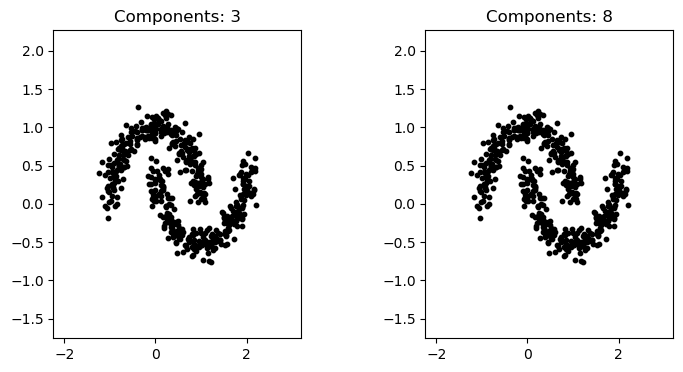

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def fit_gmm(X, n_components, max_iters=100, tol=1e-4):
    n_samples, n_features = X.shape
    np.random.seed(0)
    means = X[np.random.choice(n_samples, n_components, replace=False)]
    covariances = [np.eye(n_features) for _ in range(n_components)]
    weights = np.ones(n_components) / n_components

    means_prev = means.copy()
    covariances_prev = [cov.copy() for cov in covariances]

    for _ in range(max_iters):
        responsibilities = []
        for i in range(n_components):
            cov = covariances[i]
            diff = X - means[i]
            exponent = -0.5 * np.sum(diff @ np.linalg.inv(cov) * diff, axis=1)
            responsibilities.append(weights[i] * np.exp(exponent))
        responsibilities = np.array(responsibilities).T
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        N_k = responsibilities.sum(axis=0)
        means = (responsibilities.T @ X) / N_k[:, np.newaxis]
        covariances = [((responsibilities[:, k][:, np.newaxis] * (X - means[k])).T @ (X - means[k])) / N_k[k] for k in range(n_components)]
        weights = N_k / n_samples

        if np.all(np.abs(means - means_prev) < tol) and np.all(np.abs(covariances - covariances_prev) < tol):
            break

        means_prev = means.copy()
        covariances_prev = [cov.copy() for cov in covariances]

    return means, covariances, weights

# Number of components to try
n_components = [3, 8]

# Create subplots for each component
fig, axes = plt.subplots(1, len(n_components), figsize=(4 * len(n_components), 4))
plt.subplots_adjust(wspace=0.5)

for i, n in enumerate(n_components):
    means, covariances, _ = fit_gmm(X, n)
    mixing_coeffs = np.ones(n) / n  # Equal mixing coefficients for simplicity

    x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    X1, X2 = np.meshgrid(x, y)
    grid = np.c_[X1.ravel(), X2.ravel()]

    Z = np.zeros(grid.shape[0])
    for k in range(n):
        diff = grid - means[k]
        exponent = -0.5 * np.sum(diff @ np.linalg.inv(covariances[k]) * diff, axis=1)
        Z += mixing_coeffs[k] * np.exp(exponent)

    Z = Z.reshape(X1.shape)

    ax = axes[i]
    ax.contour(X1, X2, Z, levels=np.logspace(0, 3, 10), cmap='viridis')
    ax.scatter(X[:, 0], X[:, 1], c='black', s=10, marker='o')
    ax.set_title(f'Components: {n}')

plt.show()

